In [1]:
#Basic libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import ast
import datetime
from PIL import Image
from io import BytesIO
from datetime import datetime as dt

#Drop future warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as smpipe
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Importing the data

We start out by importing all of our data. Our datasets are from FRED and one is form the University of Michigan. Some of the FRED datasets include the GDP, the unemployment rate and of course the "USREC" which is a boolean value on if there is a recession at the current time.

The data we got from the University of Michigan is a monthly survey where participants were asked wether they would buy large household items like washing machines, stoves, dryers etc.

In [2]:
recession_vs_yield = pd.read_csv('preprocessed_data.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
recession_vs_yield = recession_vs_yield.rename(columns= {'Value': 'Unemployment', 'spread': 'Yield spread'})

#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
data_split = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_split = data_split.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_split, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

#### US Treasurery Bond datasets
Some other important FRED datasets were the annual interest rates on a 10 year US treasury bond and the annual interest rate on a 3 month US treasury bond. The difference between those two usually is a very good indicator for recession as usually when it goes negative, a recession follows.

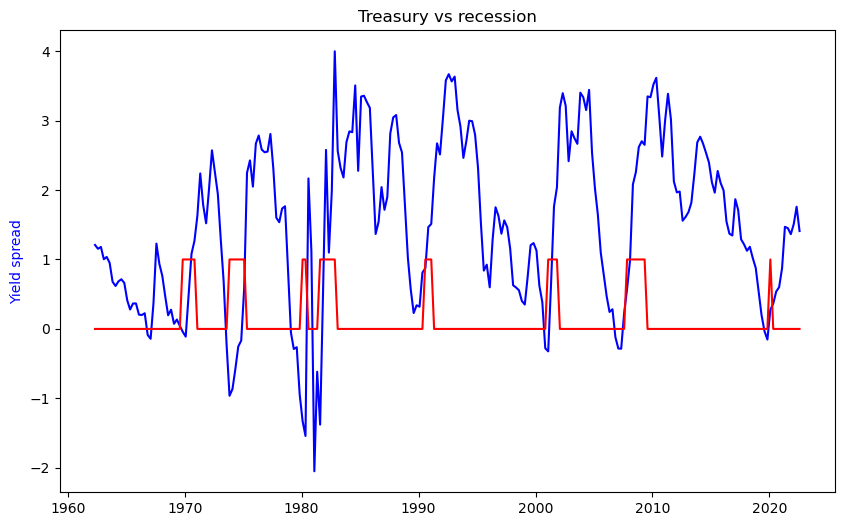

In [3]:
# plot the yield vs the recession
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(data.index, data['Yield spread_mean'], color = 'blue')
ax.plot(data.index, data['USREC'], color = 'red')
ax.set_ylabel('Yield spread', color = 'blue')
ax.tick_params(axis='y', labelcolor='black')
plt.title('Treasury vs recession')
plt.show()


#### Other data
Let us also look at the other data in our datasets to see if they are good indicators for recessions.

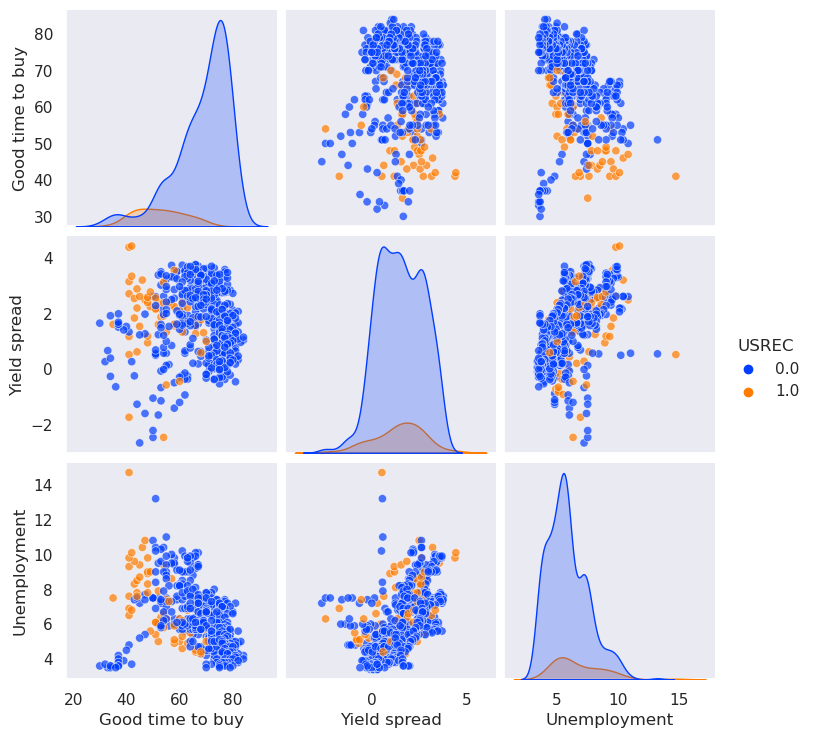

In [4]:
#sns.set(rc={'axes.facecolor':'#a8aaad', 'figure.facecolor':'#a8aaad'})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("bright")
with sns.axes_style("dark"):

    sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon', 'Uncertain - depends', 'housing market','Bad time to buy', 'Relative']), hue = 'USREC', plot_kws={'alpha': 0.7})
plt.savefig('figures/pairplots.jpg', transparent=True, dpi = 400, bbox_inches='tight');

In [5]:
data.to_csv('data/processed_data.csv')

### Preparing the training
We now split our data into test and train data. Our train-test split is 30%. We use sklearns train_test_split function to format everything correctly to train our different models

In [6]:
#Set the global X and y variables
X = data.drop(columns = ['USREC'])
y = data['USREC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)


### Training
Now we train 3 different model. They are all classifier models as we only want to predict wether or not a recession is about to hapen and not how bad the recession is. So the returned values are the probability of a recession instead of the severity.

The first model we train is a typical logistic regression. Logistic regression is the simplest model for classification as it searches for the best linear combination of the features and then computes the logarithmic odds of each class being the applicable one to the current data point. Unfortunately logistic is very easily disturbed by noisy data and overfitting. This doesn't matter to much for most applications however for our small dataset and imbalanced data the chance of overfitting is significant.

The next model is a random forest classifier. Random forest regression generates a set of trees in parallel.These trees can have different amount of branches, nodes and size. To utlimately make a prediction, we take the average of all of those trees to decide which class our current data point falls into. Because of the randomness and size difference, random forest is very resistant against overfitting and it good at predicting hard to predict data like the one we have here. This makes it good very popular for finance and economic predictions as they often have imbalenced and small amounts of data.

The last model that we chose is XGBoost which is gradient boosted trees. Similar to random forest it generates trees to make a prediction. However unlike random forest, these trees are generated sequentially and the gradient of each current tree will be taken into account for the generation of the next tree. This means that we converge way faster as we do not have to fully generate new trees that might have bad performance. Since we are using the gradient, we might get stuck in local minima though. This makes it less good for hard to predict data like the one we have here.

#### Training the models

In [7]:
#Logistic regression model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', LogisticRegression(max_iter=9000))]
lr_pipe = smpipe(steps = steps)
lr_grid = [{'rgsr__C': [1e4,1e6], 'rgsr__solver': ['newton-cg', "lbfgs", 'liblinear', 'sag', 'saga']}]
lr_grid_search = GridSearchCV(estimator = lr_pipe, param_grid = lr_grid,cv = 5, scoring = 'recall', n_jobs = -1)

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': range(50,1000,50), 'rgsr__max_depth': [2,3,4], 'rgsr__min_samples_leaf': [4]}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall', n_jobs = -1)

#XGBoost classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', GradientBoostingClassifier())]
xg_pipe = smpipe(steps = steps)
xg_grid = [{'rgsr__n_estimators': range(50,1000,50)}]
xg_grid_search = GridSearchCV(estimator = xg_pipe, param_grid = xg_grid, cv = 5, scoring = 'f1', n_jobs = -1)

#Fit the models
lr_grid_search.fit(X_train,y_train)
rf_grid_search.fit(X_train,y_train)
xg_grid_search.fit(X_train,y_train)

#Report accuracy
print('Logistic regression recall: ', recall_score(y_test,lr_grid_search.predict(X_test)))
print('Random forest regression recall: ', recall_score(y_test,rf_grid_search.predict(X_test)))
print('XGBoost regression recall: ', recall_score(y_test,xg_grid_search.predict(X_test)))

Logistic regression recall:  0.7
Random forest regression recall:  0.9
XGBoost regression recall:  0.9


Here we can already see the recall rates which is the accuracy performance of each model. Let us also plot the convergence of all models

Area under the curve logistic regression:  0.8079
Area under the curve random forest:  0.9524
Area under the curve XGBoost:  0.9587


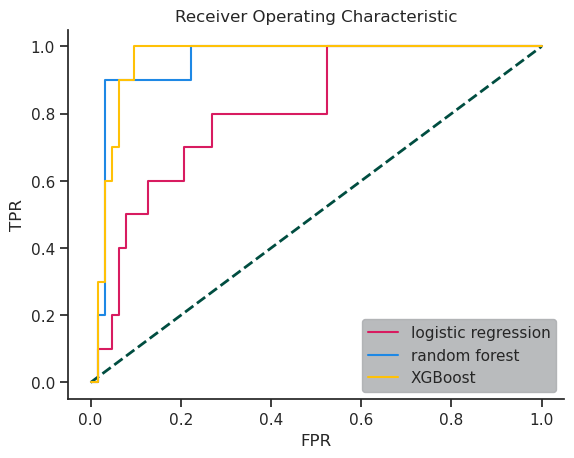

In [8]:
#For the logistic regression ROC
fpr, tpr, thresholds = roc_curve(y_test, lr_grid_search.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr, label = 'logistic regression', c = '#D81B60')
plt.plot([0, 1], [0, 1], color="#004D40", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve logistic regression: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'random forest', c = '#1E88E5')
aucscore = auc(fpr,tpr)
print('Area under the curve random forest: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, xg_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'XGBoost', c = '#FFC107')
aucscore = auc(fpr,tpr)
print('Area under the curve XGBoost: ',round(aucscore,4))


legend = plt.legend(loc = 'best')
frame = legend.get_frame()
frame.set_color('#a8aaad')
plt.savefig('figures/ROC.jpg', transparent=True, dpi = 800, bbox_inches='tight');

#### Results
As expected XGBoost converges the fastest since it is using the gradient in order to generate the next tree. Logistic regression is performing and converging almost the same as random forest. However we might have overfitted our training data which could make it hard to predict future recessions. Our random forest model is more robust against that however

To compare random forest and XGBoost we have a diagram here that can be found here:

![diagram](https://editor.analyticsvidhya.com/uploads/4661536426211ba43ea612c8e1a6a1ed45507.png)

To conclude logistic regression is the simplest approach but is very prone to overfitting, XGBoost is the fastest model but it might get stuck in local minima and random forest is the most robust because of it's random generation.

#### Accuracy and Recall rate
Let us look at how good our random forest model is at predicting recessions. It's important to note that we are only looking at the recall rate and not at the accuracy. This means we only look at the true positives and not at the false positives. This is important because we want to make sure that we don't predict a recession when there is none. This is because we want to be able to predict recessions as early as possible. If we predict a recession when there is none, we can still act accordingly. However if we don't predict a recession when there is one, we might be too late to act.

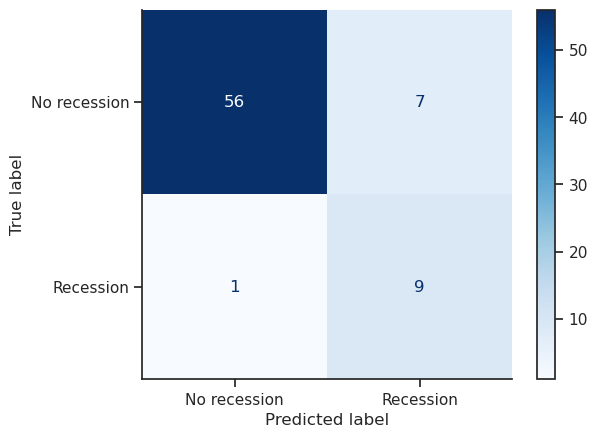

In [9]:
threshold = .5
y_probas = rf_grid_search.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > threshold else 0 for y in y_probas]
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test))
#disp = ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay.from_estimator(rf_grid_search,X_test,y_test,display_labels=('No recession','Recession'), cmap = plt.cm.Blues)
#disp.plot()
plt.savefig('figures/confMat.png', transparent=True, dpi = 800, bbox_inches='tight');

We can see that we have a recall rate of 90%. This is pretty good in terms of models. However it also means that we in 10 recessions we only predict 9. We can see this in our data as well.

To get a better recall rate we would need more data (including more recessions) to train our model further. There might also be more indicators that could lead to a better prediction

In [10]:
from sklearn.metrics import classification_report
from pprint import pprint
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)
pprint(report)

{'0.0': {'f1-score': 0.9333333333333333,
         'precision': 0.9824561403508771,
         'recall': 0.8888888888888888,
         'support': 63},
 '1.0': {'f1-score': 0.6923076923076923,
         'precision': 0.5625,
         'recall': 0.9,
         'support': 10},
 'accuracy': 0.8904109589041096,
 'macro avg': {'f1-score': 0.8128205128205128,
               'precision': 0.7724780701754386,
               'recall': 0.8944444444444444,
               'support': 73},
 'weighted avg': {'f1-score': 0.9003161222339305,
                  'precision': 0.9249279019466474,
                  'recall': 0.8904109589041096,
                  'support': 73}}


#### In terms of actual time data

Let's now look at our actual time data. Here we can see when it actually predicted the recession. This is an overall picture and we will have more in-depth data below

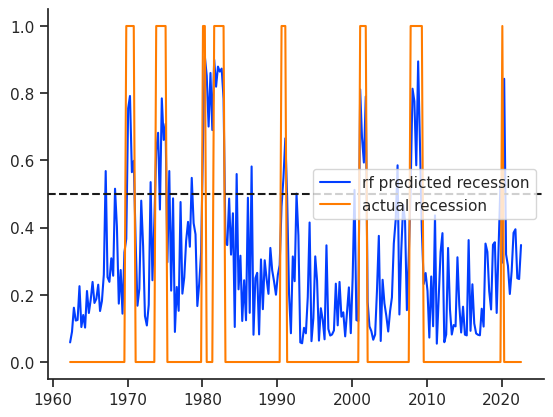

In [11]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'rf predicted recession')
#plt.plot(data.index,pd.Series(xg_grid_search.predict_proba(X)[:,1]), label = 'xg predicted recession', c = '#FFC107')
#plt.plot(data.index,pd.Series(lr_grid_search.predict_proba(X)[:,1]), label = 'lr predicted recession', c = '#D81B60')
plt.axhline(y = .5, c = 'k', ls = '--')

plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best');
plt.savefig('figures/predicted.jpg', transparent=True, dpi = 800, bbox_inches='tight');

''

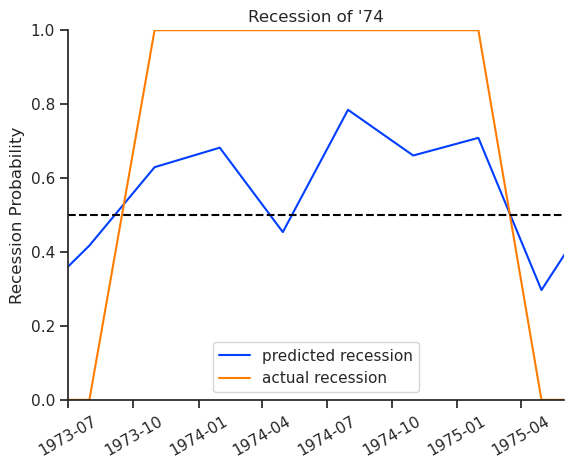

In [12]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'74')
plt.axis([dt.fromisoformat('1973-07-01'), dt.fromisoformat('1975-06-01'), 0, 1])
plt.savefig('figures/recession_of_74.png', transparent=True, dpi = 800, bbox_inches='tight')
;

''

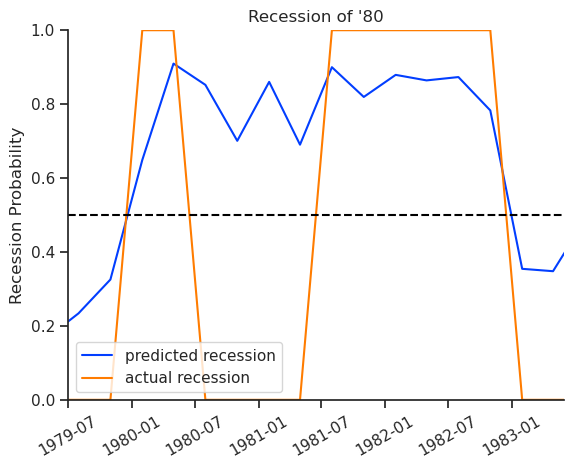

In [13]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'80')
plt.axis([dt.fromisoformat('1979-07-01'), dt.fromisoformat('1983-06-01'), 0, 1])
plt.savefig('figures/recession_of_80.png', transparent=True, dpi = 800, bbox_inches='tight')
;

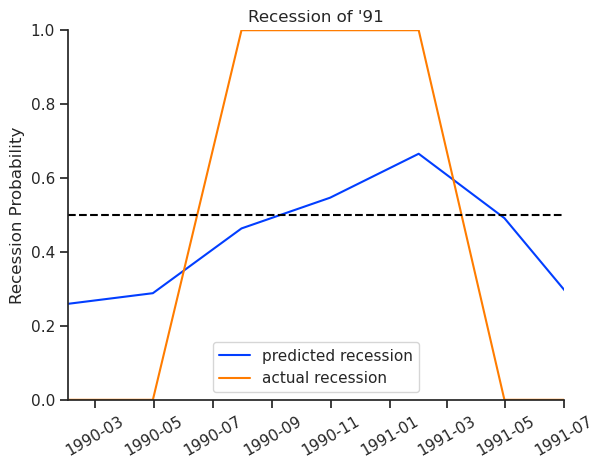

In [14]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'91')
plt.axis([dt.fromisoformat('1990-02-01'), dt.fromisoformat('1991-07-01'), 0, 1])
plt.savefig('figures/recession_of_91.png', transparent=True, dpi = 800, bbox_inches='tight');

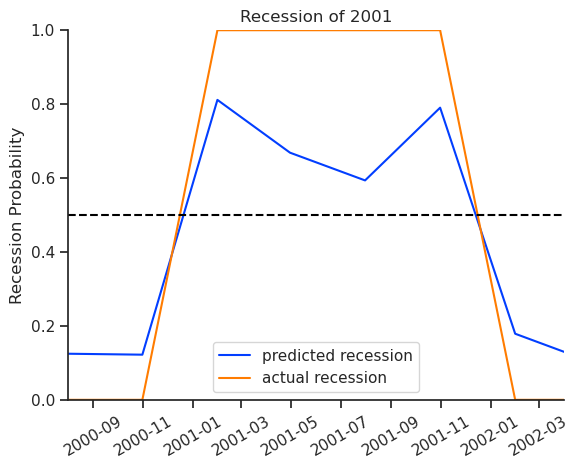

In [15]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2001')
plt.axis([dt.fromisoformat('2000-08-01'), dt.fromisoformat('2002-04-01'), 0, 1])
plt.savefig('figures/recession_of_2001.png', transparent=True, dpi = 800, bbox_inches='tight');

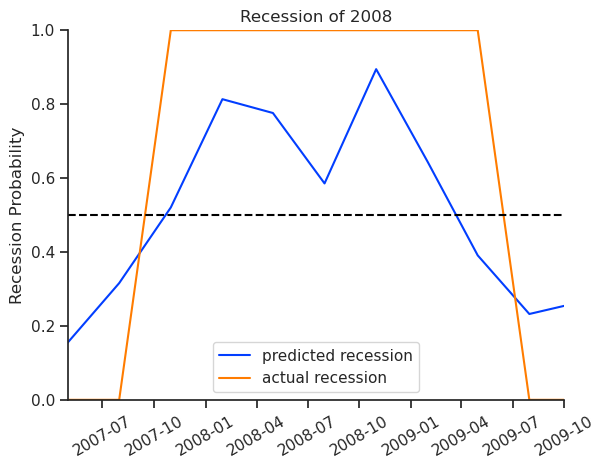

In [16]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2008')
plt.axis([dt.fromisoformat('2007-05-01'), dt.fromisoformat('2009-10-01'), 0, 1])
plt.savefig('figures/recession_of_2008.png', transparent=True, dpi = 800, bbox_inches='tight');

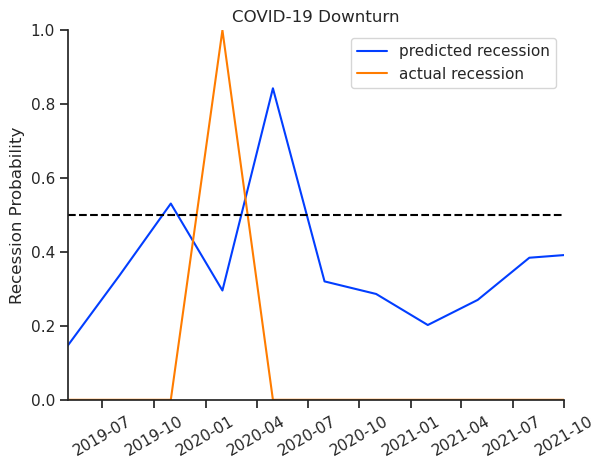

In [17]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')

plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('COVID-19 Downturn')
plt.axis([dt.fromisoformat('2019-05-01'), dt.fromisoformat('2021-10-01'), 0, 1])
plt.savefig('figures/COVID.png', transparent=True, dpi = 800, bbox_inches='tight');

#### Saving our model

In [18]:
#Store the model for later use
import joblib

recession = pd.DataFrame(rf_grid_search.predict_proba(X)[:,1], index = data.index, columns = ['recession'])

with open('models/recession_probs.pkl', 'wb') as f:
    joblib.dump(recession, f)

### Most important features

Now let's take a look at which features were the most important ones in order to predict recessions. To make the graphs more readable we only look at the top ten features.

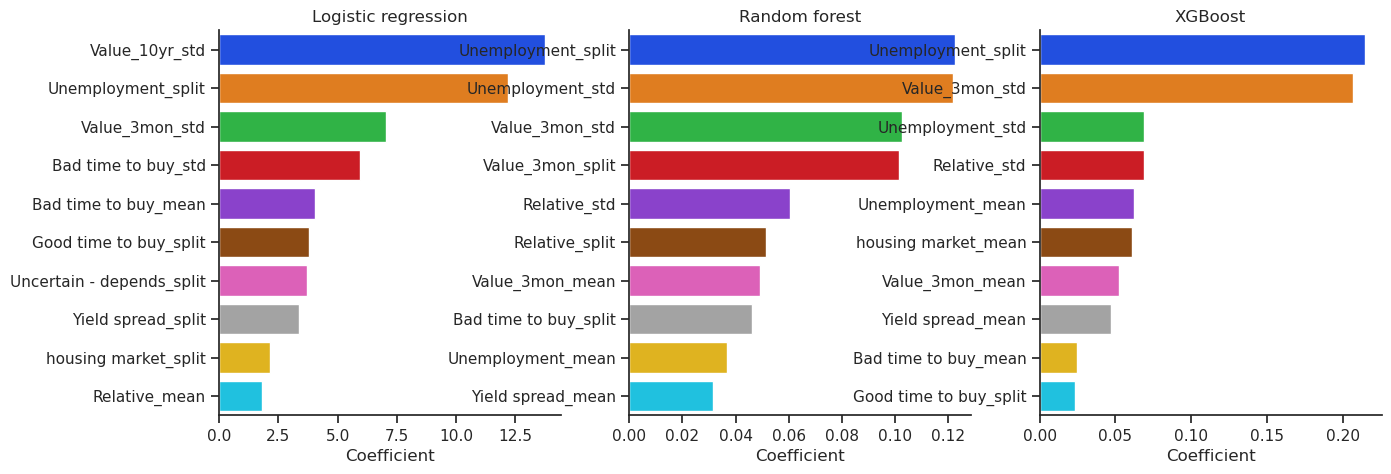

In [19]:
# get coefficients
lr_coef = pd.DataFrame(lr_grid_search.best_estimator_.named_steps['rgsr'].coef_, columns = X.columns)
lr_coef = lr_coef.T
lr_coef.columns = ['Coefficient']
lr_coef = lr_coef.sort_values(by = 'Coefficient', ascending = False)
rf_coef = pd.DataFrame(rf_grid_search.best_estimator_.named_steps['rgsr'].feature_importances_, columns = ['Coefficient'], index = X.columns)
rf_coef = rf_coef.sort_values(by = 'Coefficient', ascending = False)
xg_coef = pd.DataFrame(xg_grid_search.best_estimator_.named_steps['rgsr'].feature_importances_, columns = ['Coefficient'], index = X.columns)
xg_coef = xg_coef.sort_values(by = 'Coefficient', ascending = False)

# only show the best 10 features
lr_coef = lr_coef.iloc[:10,:]
rf_coef = rf_coef.iloc[:10,:]
xg_coef = xg_coef.iloc[:10,:]

 # plotting the coefficients
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.barplot(x = lr_coef['Coefficient'], y = lr_coef.index, ax = ax[0])
ax[0].set_title('Logistic regression')
sns.barplot(x = rf_coef['Coefficient'], y = rf_coef.index, ax = ax[1])
ax[1].set_title('Random forest')
sns.barplot(x = xg_coef['Coefficient'], y = xg_coef.index, ax = ax[2])
ax[2].set_title('XGBoost')
plt.savefig('figures/coefficients10.png', transparent=True, dpi = 400, bbox_inches='tight');

It was suprising that for the different models different features were more important. For logistic regression we can see that the value10yr and bad time to buy are in the top three features. However we cannot see those features high up in random forest and XGBoost. We also notice that relative_std and the 3 month treasury bond values were more important to XGBoost compared to random forest. For random forest we can also see that unemployment and yield are more important. Suprisingly the housing market was not really found in the top ten values of random forest.

#### Conclusion
From this we can conclude that the 3 month treasury bond indicators made it converge faster but are also leading us to a locla minima. The overall best indicator seems to be the unemployment rate. We can also see that the two survey values "Good time to buy" and "Bad time to buy" are not really relevant in order to predict recessions.We also saw that the housing market does not seem to be as important as expected.

''

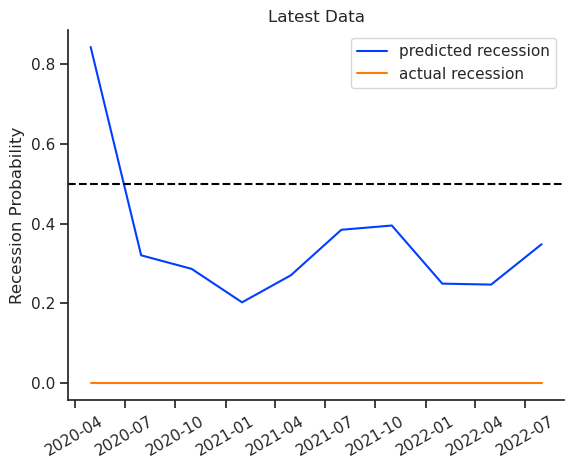

In [20]:
#plot last 10 items in the recession probability series
fig, ax = plt.subplots()
plt.plot(data.index[-10:],pd.Series(rf_grid_search.predict_proba(X)[:,1])[-10:], label = 'predicted recession')
plt.plot(data.index[-10:],data['USREC'][-10:],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Latest Data')
plt.savefig('figures/latest_data.png', transparent=True, dpi = 400, bbox_inches='tight');
;

In [21]:
# train again but monthly
data = pd.read_csv('preprocessed_data.csv', index_col = 0, parse_dates = True)
data = data.resample('M').mean()
data = data.dropna()
X = data.drop(columns = ['USREC'])
y = data['USREC']

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': range(50,1000,50), 'rgsr__max_depth': [2,3,4], 'rgsr__min_samples_leaf': [4]}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall', n_jobs = -1)

# fit the model
rf_grid_search.fit(X,y)
print(f'Recall: {rf_grid_search.best_score_}')

Recall: 0.7015151515151515


In [22]:
# XGBoost model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', GradientBoostingClassifier())]
xg_pipe = smpipe(steps = steps)
xg_grid = [{'rgsr__n_estimators': range(50,1000,50), 'rgsr__max_depth': [2,3,4], 'rgsr__min_samples_leaf': [4]}]
xg_grid_search = GridSearchCV(estimator = xg_pipe, param_grid = xg_grid, cv = 5, scoring = 'recall', n_jobs = -1)

# fit the model
xg_grid_search.fit(X,y)
print(f'Recall: {xg_grid_search.best_score_}')

Recall: 0.5878787878787879


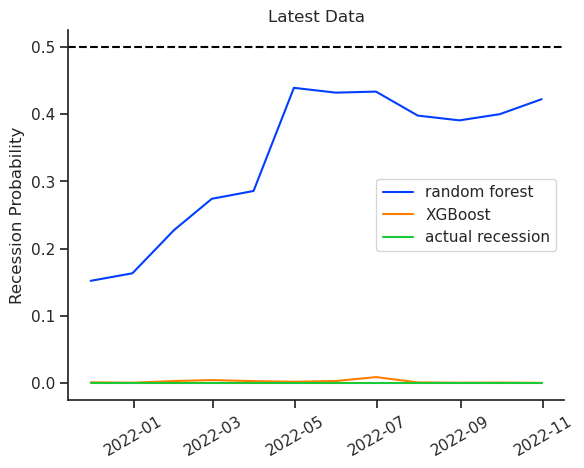

In [23]:
#plot both models for the latest 12 months
fig, ax = plt.subplots()
plt.plot(data.index[-12:],pd.Series(rf_grid_search.predict_proba(X)[:,1])[-12:], label = 'random forest')
plt.plot(data.index[-12:],pd.Series(xg_grid_search.predict_proba(X)[:,1])[-12:], label = 'XGBoost')
plt.plot(data.index[-12:],data['USREC'][-12:],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Latest Data')
plt.savefig('figures/latest_data_monthly_both.png', transparent=True, dpi = 400, bbox_inches='tight');

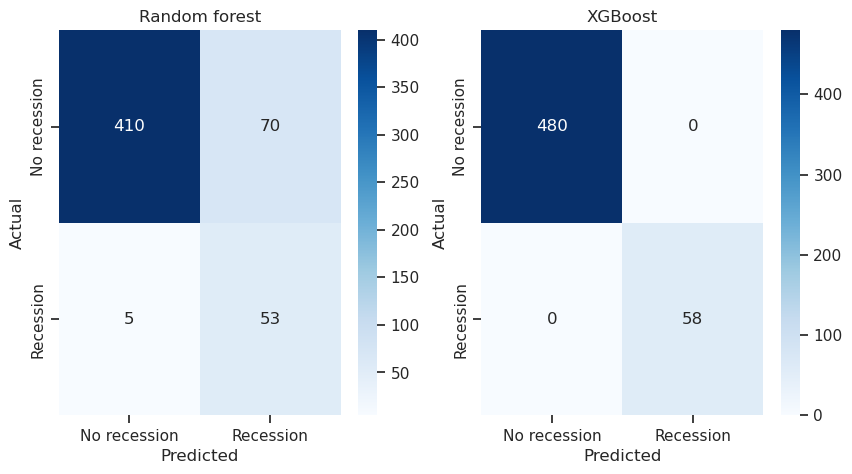

In [24]:
def plot_confusion_matrix(model, X, y, ax, cmap = 'Blues'):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = ax, cmap = cmap)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['No recession', 'Recession'])
    ax.set_yticklabels(['No recession', 'Recession'])

# graph the confusion matrix for both models
fig, ax = plt.subplots(1,2, figsize = (10,5))
plot_confusion_matrix(rf_grid_search, X, y, ax = ax[0], cmap = 'Blues')
ax[0].set_title('Random forest')
plot_confusion_matrix(xg_grid_search, X, y, ax = ax[1], cmap = 'Blues')
ax[1].set_title('XGBoost')
plt.savefig('figures/confusion_matrix.png', transparent=True, dpi = 400, bbox_inches='tight');

Text(0.5, 1.0, 'Random forest')

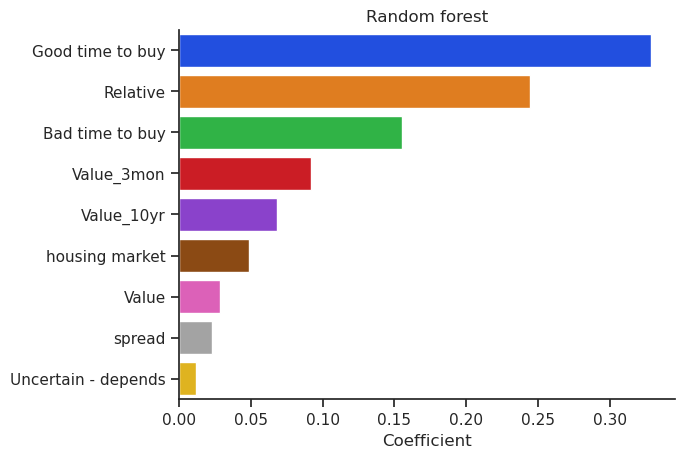

In [25]:
# top 10 features
rf_coef = pd.DataFrame(rf_grid_search.best_estimator_.named_steps['rgsr'].feature_importances_, columns = ['Coefficient'], index = X.columns)
rf_coef = rf_coef.sort_values(by = 'Coefficient', ascending = False)
rf_coef = rf_coef.iloc[:10,:]

# plot the top 10 features
fig, ax = plt.subplots()
sns.barplot(x = rf_coef['Coefficient'], y = rf_coef.index, ax = ax)
ax.set_title('Random forest')
#plt.savefig('figures/coefficients10_monthly.png', transparent=True, dpi = 400, bbox_inches='tight');

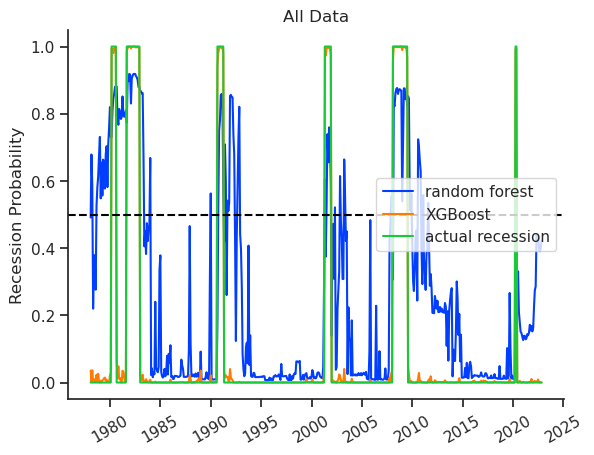

In [26]:
#plot all of xgboost's predictions
fig, ax = plt.subplots()
plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'random forest')
plt.plot(data.index,pd.Series(xg_grid_search.predict_proba(X)[:,1]), label = 'XGBoost')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('All Data')
plt.savefig('figures/all_data_monthly.png', transparent=True, dpi = 400, bbox_inches='tight');


Text(0.5, 1.0, 'Covid-19 Recession')

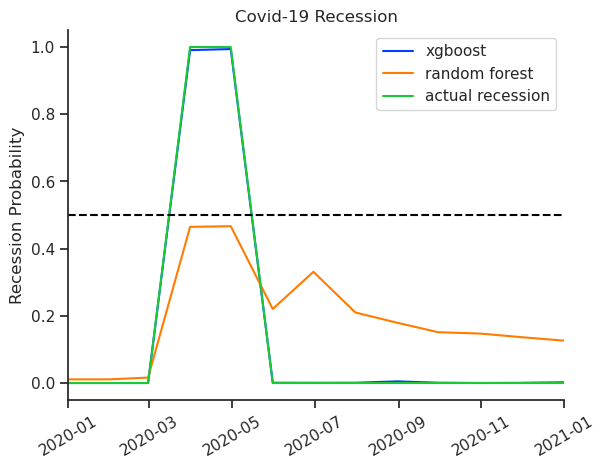

In [27]:
#plot all of xgboost's predictions
fig, ax = plt.subplots()
plt.plot(data.index,pd.Series(xg_grid_search.predict_proba(X)[:,1]), label = 'xgboost')
plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'random forest')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
#only plot from 2020 to now
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2021-01-01'))
plt.title('Covid-19 Recession')
#plt.savefig('figures/all_data_monthly.png', transparent=True, dpi = 400, bbox_inches='tight');
